# PENNANT
PENNANT is an unstructured mesh physics mini-app designed for advanced
architecture research.  It contains mesh data structures and a few
physics algorithms adapted from the LANL rad-hydro code FLAG, and gives
a sample of the typical memory access patterns of FLAG.

---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -O3 -march=native -fopenmp'
Run_Flags = '../test/leblancbig/leblancbig.pnt'
```

#### NOTE: Compiler specific directives for Intel Compiler
```c
#pragma ivdep
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

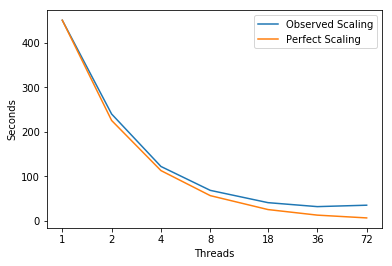

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, [451.0, 240.0, 122.0, 68.25, 40.611111111111114, 31.666666666666668, 34.861111111111114],
        label='Observed Scaling')
ax.plot(Threads, [451.0, 225.5, 112.75, 56.375, 25.055555555555557, 12.527777777777779, 6.263888888888889],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate

| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |        1.4          |         5.5% |         17.5% |     26.4% |                0.76     |       16.2% |        3.8%  |       2.1%    |
| 72                           |  100.0 %   |        0.8          |         4.9% |         25.6% |     18.1% |                0.36     |       14.0% |        5.0%  |       8.5%    |

---
## QCS::setCornerDiv( )
| QCS::setCornerDiv() | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------------------------------------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                                                                        |  34.2 %   |        1.5          |         2.3% |         14.2% |      1.2% |                0.68     |        6.0% |        1.1%  |       0.0%    |
| 72                                                                       |  13.4 %   |        1.5          |         2.6% |         25.1% |      2.5% |                0.62     |       13.0% |        4.5%  |       1.1%    |
```c++
 87 // Routine number [2]  in the full algorithm
 88 //     [2.1] Find the corner divergence
 89 //     [2.2] Compute the cos angle for c
 90 //     [2.3] Find the evolution factor c0evol(c)
 91 //           and the Delta u(c) = du(c)
 92 void QCS::setCornerDiv(
 93             double* c0area,
 94             double* c0div,
 95             double* c0evol,
 96             double* c0du,
 97             double* c0cos,
 98             const int sfirst,
 99             const int slast) {
100 
101     const Mesh* mesh = hydro->mesh;
102     const int nums = mesh->nums;
103     const int numz = mesh->numz;
104 
105     const double2* pu = hydro->pu;
106     const double2* px = mesh->pxp;
107     const double2* ex = mesh->exp;
108     const double2* zx = mesh->zxp;
109     const double* elen = mesh->elen;
110     const int* znump = mesh->znump;
111 
112     int cfirst = sfirst;
113     int clast = slast;
114     int zfirst = mesh->mapsz[sfirst];
115     int zlast = (slast < nums ? mesh->mapsz[slast] : numz);
116 
117     double2* z0uc = Memory::alloc<double2>(zlast - zfirst);
118     double2 up0, up1, up2, up3;
119     double2 xp0, xp1, xp2, xp3;
120 
121     // [1] Compute a zone-centered velocity
122     fill(&z0uc[0], &z0uc[zlast-zfirst], double2(0., 0.));
123     for (int c = cfirst; c < clast; ++c) {
124         int p = mesh->mapsp1[c];
125         int z = mesh->mapsz[c];
126         int z0 = z - zfirst;
127         z0uc[z0] += pu[p];
128     }
129 
130     for (int z = zfirst; z < zlast; ++z) {
131         int z0 = z - zfirst;
132         z0uc[z0] /= (double) znump[z];
133     }
134 
135     // [2] Divergence at the corner
136     #pragma ivdep
137     for (int c = cfirst; c < clast; ++c) {
138         int s2 = c;
139         int s = mesh->mapss3[s2];
140         // Associated zone, corner, point
141         int z = mesh->mapsz[s];
142         int z0 = z - zfirst;
143         int c0 = c - cfirst;
144         int p = mesh->mapsp2[s];
145         // Points
146         int p1 = mesh->mapsp1[s];
147         int p2 = mesh->mapsp2[s2];
148         // Edges
149         int e1 = mesh->mapse[s];
150         int e2 = mesh->mapse[s2];
151 
152         // Velocities and positions
153         // 0 = point p
154         up0 = pu[p];
155         xp0 = px[p];
156         // 1 = edge e2
157         up1 = 0.5 * (pu[p] + pu[p2]);
158         xp1 = ex[e2];
159         // 2 = zone center z
160         up2 = z0uc[z0];
161         xp2 = zx[z];
162         // 3 = edge e1
163         up3 = 0.5 * (pu[p1] + pu[p]);
164         xp3 = ex[e1];
165 
166         // compute 2d cartesian volume of corner
167         double cvolume = 0.5 * cross(xp2 - xp0, xp3 - xp1);
168         c0area[c0] = cvolume;
169 
170         // compute cosine angle
171         double2 v1 = xp3 - xp0;
172         double2 v2 = xp1 - xp0;
173         double de1 = elen[e1];
174         double de2 = elen[e2];
175         double minelen = min(de1, de2);
176         c0cos[c0] = ((minelen < 1.e-12) ?
177                 0. :
178                 4. * dot(v1, v2) / (de1 * de2));
179 
180         // compute divergence of corner
181         c0div[c0] = (cross(up2 - up0, xp3 - xp1) -
182                 cross(up3 - up1, xp2 - xp0)) /
183                 (2.0 * cvolume);
184 
185         // compute evolution factor
186         double2 dxx1 = 0.5 * (xp1 + xp2 - xp0 - xp3);
187         double2 dxx2 = 0.5 * (xp2 + xp3 - xp0 - xp1);
188         double dx1 = length(dxx1);
189         double dx2 = length(dxx2);
190 
191         // average corner-centered velocity
192         double2 duav = 0.25 * (up0 + up1 + up2 + up3);
193 
194         double test1 = abs(dot(dxx1, duav) * dx2);
195         double test2 = abs(dot(dxx2, duav) * dx1);
196         double num = (test1 > test2 ? dx1 : dx2);
197         double den = (test1 > test2 ? dx2 : dx1);
198         double r = num / den;
199         double evol = sqrt(4.0 * cvolume * r);
200         evol = min(evol, 2.0 * minelen);
201 
202         // compute delta velocity
203         double dv1 = length2(up1 + up2 - up0 - up3);
204         double dv2 = length2(up2 + up3 - up0 - up1);
205         double du = sqrt(max(dv1, dv2));
206 
207         c0evol[c0] = (c0div[c0] < 0.0 ? evol : 0.);
208         c0du[c0]   = (c0div[c0] < 0.0 ? du   : 0.);
209     }  // for s
210 
211     Memory::free(z0uc);
212 }
```

---
## QCS::setQCnForce( )
| QCS::setQCnForce() | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:----------------------------------------------------------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                                                                                 |  11.6 %   |        1.0          |         5.7% |         13.9% |      0.0% |                0.71     |       14.3% |        2.7%  |       0.0%    |
| 72                                                                                |  4.4 %   |        1.1          |         6.3% |         24.8% |      0.6% |                0.66     |       31.1% |       10.7%  |       0.7%    |
```c++
// Routine number [4]  in the full algorithm CS2DQforce(...)
void QCS::setQCnForce(
        const double* c0div,
        const double* c0du,
        const double* c0evol,
        double2* c0qe,
        const int sfirst,
        const int slast) {

    const Mesh* mesh = hydro->mesh;

    const double2* pu = hydro->pu;
    const double* zrp = hydro->zrp;
    const double* zss = hydro->zss;
    const double* elen = mesh->elen;

    int cfirst = sfirst;
    int clast = slast;

    double* c0rmu = Memory::alloc<double>(clast - cfirst);

    const double gammap1 = qgamma + 1.0;

    // [4.1] Compute the c0rmu (real Kurapatenko viscous scalar)
    #pragma ivdep
    for (int c = cfirst; c < clast; ++c) {
        int c0 = c - cfirst;
        int z = mesh->mapsz[c];

        // Kurapatenko form of the viscosity
        double ztmp2 = q2 * 0.25 * gammap1 * c0du[c0];
        double ztmp1 = q1 * zss[z];
        double zkur = ztmp2 + sqrt(ztmp2 * ztmp2 + ztmp1 * ztmp1);
        // Compute c0rmu for each corner
        double rmu = zkur * zrp[z] * c0evol[c0];
        c0rmu[c0] = ((c0div[c0] > 0.0) ? 0. : rmu);

    } // for c

    // [4.2] Compute the c0qe for each corner
    #pragma ivdep
    for (int c = cfirst; c < clast; ++c) {
        int s4 = c;
        int s = mesh->mapss3[s4];
        int c0 = c - cfirst;
        int p = mesh->mapsp2[s];
        // Associated point and edge 1
        int p1 = mesh->mapsp1[s];
        int e1 = mesh->mapse[s];
        // Associated point and edge 2
        int p2 = mesh->mapsp2[s4];
        int e2 = mesh->mapse[s4];

        // Compute: c0qe(1,2,3)=edge 1, y component (2nd), 3rd corner
        //          c0qe(2,1,3)=edge 2, x component (1st)
        c0qe[2 * c0]     = c0rmu[c0] * (pu[p] - pu[p1]) / elen[e1];
        c0qe[2 * c0 + 1] = c0rmu[c0] * (pu[p2] - pu[p]) / elen[e2];

    } // for s

    Memory::free(c0rmu);
}

```

---
## Mesh::calcCtrs( )
| Mesh::calcCtrs() | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------------------------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                                                            |  6.1 %   |        1.2          |         7.9% |         21.2% |     24.7% |                0.84     |       25.8% |        7.3%  |       3.8%    |
| 72                                                           |  7.9 %   |       0.44          |         7.6% |         26.1% |     31.9% |                0.23     |       14.7% |        5.3%  |      15.9%    |
```c++
void Mesh::calcCtrs(
        const double2* px,
        double2* ex,
        double2* zx,
        const int sfirst,
        const int slast) {

    int zfirst = mapsz[sfirst];
    int zlast = (slast < nums ? mapsz[slast] : numz);
    fill(&zx[zfirst], &zx[zlast], double2(0., 0.));

    for (int s = sfirst; s < slast; ++s) {
        int p1 = mapsp1[s];
        int p2 = mapsp2[s];
        int e = mapse[s];
        int z = mapsz[s];
        ex[e] = 0.5 * (px[p1] + px[p2]);
        zx[z] += px[p1];
    }

    for (int z = zfirst; z < zlast; ++z) {
        zx[z] /= (double) znump[z];
    }

}
```

---
## Mesh::calcVols( )
| Mesh::calcVols() | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:---------------------------------------------------------------------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                                                                                            |  7.3 %   |        1.7          |         2.9% |         21.1% |     15.9% |                0.82     |       10.6% |        3.0%  |       1.0%    |
| 72                                                                                           |  7.6 %   |       0.84          |         4.9% |         25.5% |     14.4% |                0.27     |       12.4% |        4.4%  |       5.9%    |
```c++
void Mesh::calcVols(
        const double2* px,
        const double2* zx,
        double* sarea,
        double* svol,
        double* zarea,
        double* zvol,
        const int sfirst,
        const int slast) {

    int zfirst = mapsz[sfirst];
    int zlast = (slast < nums ? mapsz[slast] : numz);
    fill(&zvol[zfirst], &zvol[zlast], 0.);
    fill(&zarea[zfirst], &zarea[zlast], 0.);

    const double third = 1. / 3.;
    int count = 0;
    for (int s = sfirst; s < slast; ++s) {
        int p1 = mapsp1[s];
        int p2 = mapsp2[s];
        int z = mapsz[s];

        // compute side volumes, sum to zone
        double sa = 0.5 * cross(px[p2] - px[p1], zx[z] - px[p1]);
        double sv = third * sa * (px[p1].x + px[p2].x + zx[z].x);
        sarea[s] = sa;
        svol[s] = sv;
        zarea[z] += sa;
        zvol[z] += sv;

        // check for negative side volumes
        if (sv <= 0.) count += 1;

    } // for s

    if (count > 0) {
        #pragma omp atomic
        numsbad += count;
    }

}

```

Does not pressure system. Time is spent in many different places. Many other functions taking 1-2% of Time. Time spent waiting in openMP library (10.4%).  Hyper-threading hurts performance.  
TODO: Other test inputs (sedov, noh)

## Additional Investigation
Look into amount of calls and control flow???